In [1]:
%load_ext autoreload
%autoreload 2
%cd ..
import sys
sys.path.append("/Users/ahmetayrnc/Documents/04-scripts/deep_active_learning/")

/home/ahmet/deep-active-learning-2


In [2]:
from data import get_DYDA, get_SWDA, get_KPN
train, test = get_KPN()

len(train[0])

Dataset loaded from disk


2163

# KPN Data Prep

In [5]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import DatasetDict, Dataset

replace_map = {
    "mechanic planned": "action planned",
    "back office_answer": "back office",
    "consultation_answer": "consultation",
    "transfer_answer": "transfer",
    "following_procedure": "follow procedure",
    "will try solution": "suggest solution",
    "mechanic planned_answer": "action planned",
}


def convert_kpn_data():
    # read the csv
    df = pd.read_csv("kpn.csv", index_col=0)

    df = df.reset_index(drop=True)

    # drop the unnecessary columns
    df = df.drop(columns=["segments", "actor_id"])

    # remove the brackets from the dialogue acts
    df["dialogue_acts"] = df["dialogue_acts"].apply(lambda x: x.strip("['']"))

    df['dialogue_acts'] = df['dialogue_acts'].replace(replace_map)

    # encode the labels
    le = LabelEncoder()
    df["label"] = le.fit_transform(df["dialogue_acts"])

    print(le.classes_)

    # sort the turns by turn order
    df = (
        df.groupby("conversation_id", group_keys=True)
        .apply(lambda x: x.sort_values(by=["order"]))
        .reset_index(drop=True)
    )

    # create the nested structure
    df = df.groupby("conversation_id").agg(list)

    display(df)

    # remove the conversations with more than 4000 tokens
    total_length = lambda text_list: sum([len(text) for text in text_list])
    df = df[df["text"].apply(total_length) / 4 < 4000]

    # split the data into train and test
    train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)
    print(train_data.shape, test_data.shape)

    # create the dataset dict
    train_dataset = Dataset.from_pandas(train_data)
    test_dataset = Dataset.from_pandas(test_data)
    dataset_dict = DatasetDict({"train": train_dataset, "test": test_dataset})

    os.makedirs("data/kpn", exist_ok=True)
    dataset_dict.save_to_disk("data/kpn")


convert_kpn_data()

['NDS' 'action planned' 'back office' 'consultation'
 'customer recognition' 'explore problem' 'farewell' 'follow procedure'
 'greeting' 'my problem is' 'solved' 'suggest solution' 'transfer']


,order,text,dialogue_acts,label
conversation_id,,,,
20201123_080634_SQKV,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[goedemorgen kpn, goeiedag met essen bedjes ik...","[greeting, my problem is, customer recognition...","[8, 9, 4, 4, 4, 4, 4, 4, 0, 4, 4, 9, 12, 6, 8,..."
20201123_082708_SRRD,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[morgen zou dat zo is, goedemorgen met uh alle...","[action planned, my problem is, explore proble...","[1, 9, 5, 4, 0, 4, 9, 9, 4, 0, 0, 0, 0, 0, 0, ..."
20201123_084904_STVW,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",[die. goedemorgen met ... van kpn zakelijk waa...,"[greeting, greeting, NDS, my problem is, custo...","[8, 8, 0, 9, 4, 0, 4, 4, 4, 9, 5, 9, 5, 9, 12,..."
20201123_085032_SUAJ,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",[zo. je bent u dat al ja daarom. niet. nou als...,"[NDS, greeting, my problem is, greeting, NDS, ...","[0, 8, 9, 8, 0, 4, 4, 3, 3, 4, 0, 4, 4, 4, 4, ..."
20201123_092336_SYUH,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[dat zou .... ja. worden opgenomen, goedemorge...","[NDS, greeting, my problem is, greeting, custo...","[0, 8, 9, 8, 4, 0, 0, 4, 4, 4, 0, 0, 4, 0, 0, ..."
...,...,...,...,...
20210117_132830_RXSH,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",[goedemiddag kpn kleinzakelijk u spreekt met u...,"[greeting, greeting, customer recognition, NDS...","[8, 8, 4, 0, 0, 4, 0, 0, 0, 0, 9, 5, 9, 3, 12,..."
20210117_151715_SCKP,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",[een goede middag kpn receptie ... cardiff waa...,"[greeting, my problem is, customer recognition...","[8, 9, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 0, 0, ..."
20210117_152258_JIDJ,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[een hele goeie dag met kpn kleinzakelijk, ja ...","[greeting, my problem is, follow procedure, fo...","[8, 9, 7, 7, 7, 8, 0, 7, 7, 9, 7, 6, 6]"


(2163, 4) (241, 4)


Saving the dataset (0/1 shards):   0%|          | 0/2163 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/241 [00:00<?, ? examples/s]

# Dataset Statistics

Dataset loaded from disk


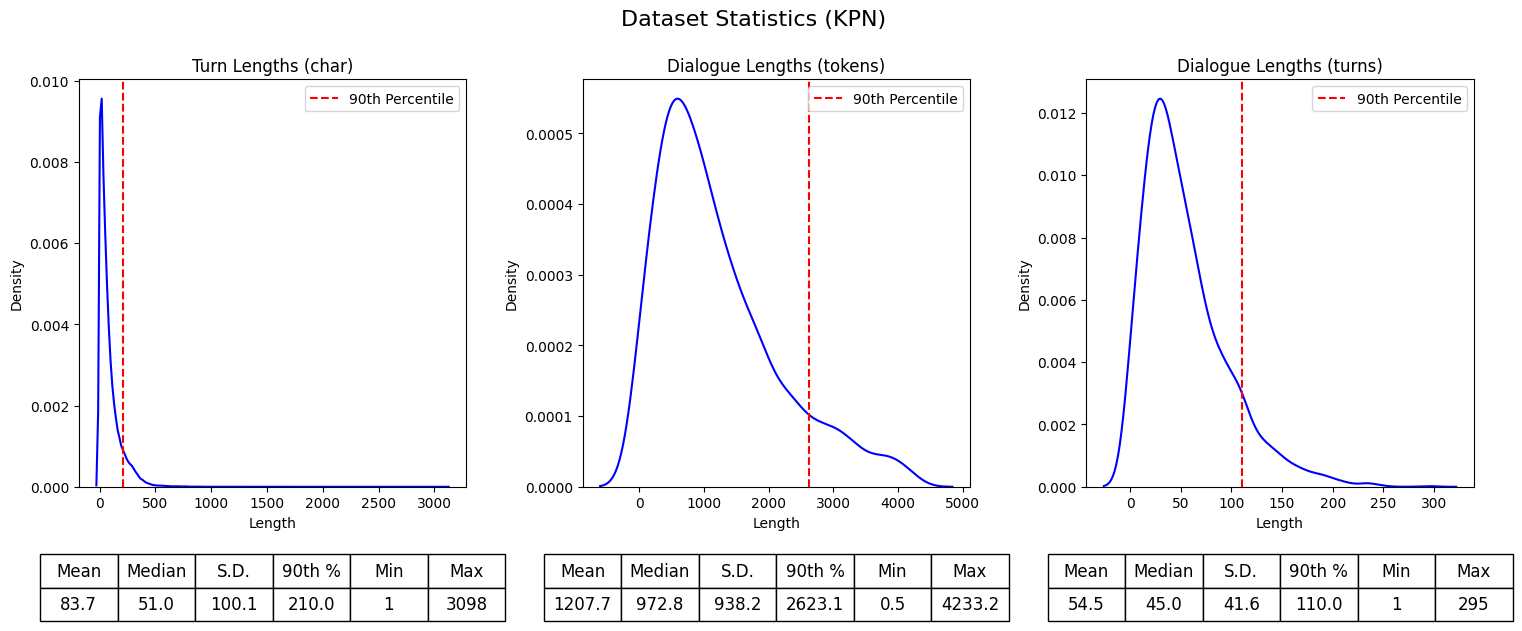

In [3]:
from data import get_DYDA, get_SWDA, get_KPN
from plot_distributions import display_dataset_statistics

train, test = get_KPN()

display_dataset_statistics(train, 'KPN')

# Uncertainty Clipping Visualization

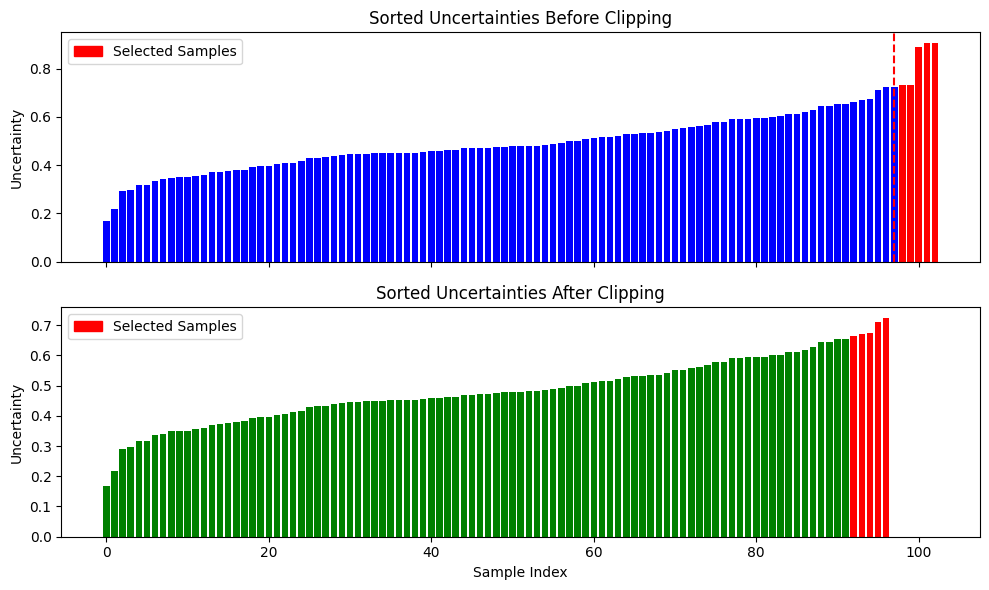

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def UC_visual_aid():

    def clip_uncertainties(uncertainties, k):
        threshold = np.percentile(uncertainties, 100 - k)
        remaining_uncertainties = np.array([u for u in uncertainties if u <= threshold])
        return remaining_uncertainties, threshold

    # Example uncertainties with a few highly uncertain samples
    uncertainties = np.random.normal(0.5, 0.1, 100)
    uncertainties = np.append(uncertainties, np.random.normal(0.9, 0.01, 3))

    # Set the clipping percentage
    k = 5

    # Clip the uncertainties
    remaining_uncertainties, threshold = clip_uncertainties(uncertainties, k)

    # Sort the uncertainties
    sorted_original = np.sort(uncertainties)
    sorted_remaining = np.sort(remaining_uncertainties)

    # Select the top 5 samples before and after clipping
    top5_original = np.sort(sorted_original)[-5:]
    top5_remaining = np.sort(sorted_remaining)[-5:]

    # Create the bar chart
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # Plot original uncertainties and color selected samples red
    colors_original = ['red' if u in top5_original else 'blue' for u in sorted_original]
    ax1.bar(range(len(sorted_original)), sorted_original, color=colors_original)

    # Plot remaining uncertainties after clipping and color selected samples red
    colors_remaining = ['red' if u in top5_remaining else 'green' for u in sorted_remaining]
    ax2.bar(range(len(sorted_remaining)), sorted_remaining, color=colors_remaining)

    ax1.axvline(x=np.sum(sorted_remaining <= threshold), linestyle='--', color='red', label='Cut-off Threshold')

    # Add labels and formatting
    ax1.set_ylabel('Uncertainty')
    ax1.set_title('Sorted Uncertainties Before Clipping')

    ax2.set_ylabel('Uncertainty')
    ax2.set_title('Sorted Uncertainties After Clipping')
    ax2.set_xlabel('Sample Index')

    # Create custom legend elements
    selected_patch = Patch(color='red', label='Selected Samples')

    # Add legends to both subplots
    ax1.legend(handles=[selected_patch])
    ax2.legend(handles=[selected_patch])

    # Display the plot
    plt.tight_layout()
    plt.show()

UC_visual_aid()

# Learning Curve Visualization

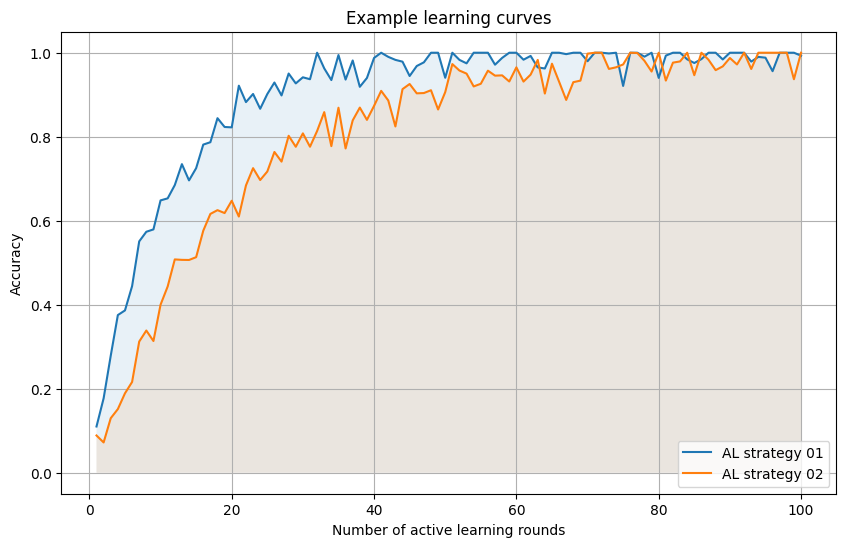

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def example_learning_curve_with_noise(steepness, seed=None):
    if seed:
        np.random.seed(seed)
    x = np.arange(1, 101)
    y = 1 - np.exp(-steepness * x)
    noise = np.random.normal(0, 0.03, len(y))
    y_noisy = np.clip(y + noise, 0, 1)
    return x, y_noisy

# Generate example learning curves for two active learning strategies
x, strategy_1 = example_learning_curve_with_noise(0.1, seed=42)
_, strategy_2 = example_learning_curve_with_noise(0.05, seed=24)

plt.figure(figsize=(10, 6))

plt.plot(x, strategy_1, label='AL strategy 01')
plt.plot(x, strategy_2, label='AL strategy 02')

# Highlight the area under the curve
plt.fill_between(x, 0, strategy_1, alpha=0.1)
plt.fill_between(x, 0, strategy_2, alpha=0.1)

plt.xlabel('Number of active learning rounds')
plt.ylabel('Accuracy')
plt.title('Example learning curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Sequence Similarity Visualization

Dataset loaded from disk


/home/ahmet/deep-active-learning-2/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ahmet/deep-active-learning-2/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ahmet/deep-active-learning-2/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/ahmet/deep-active-learning-2/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:78

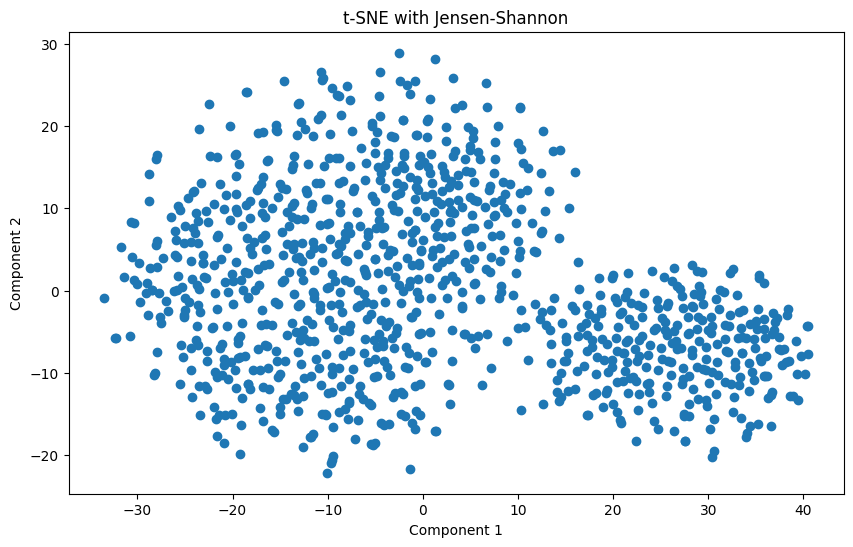

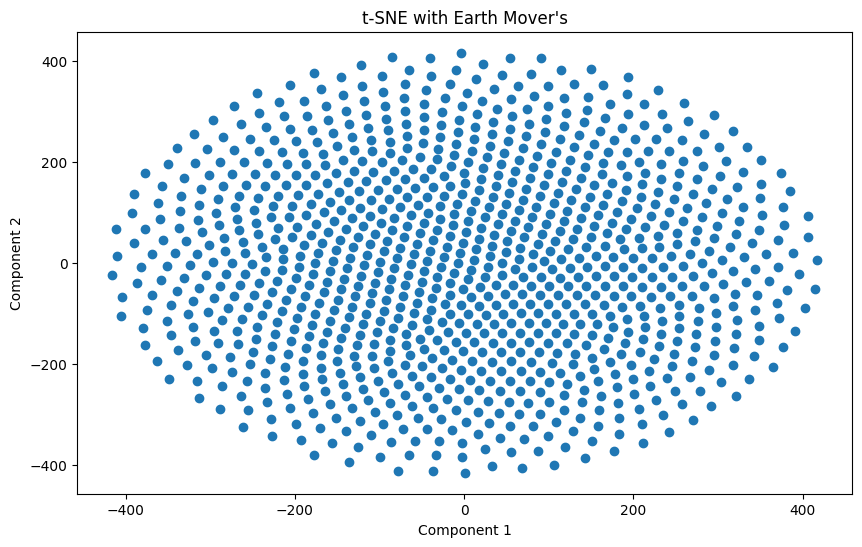

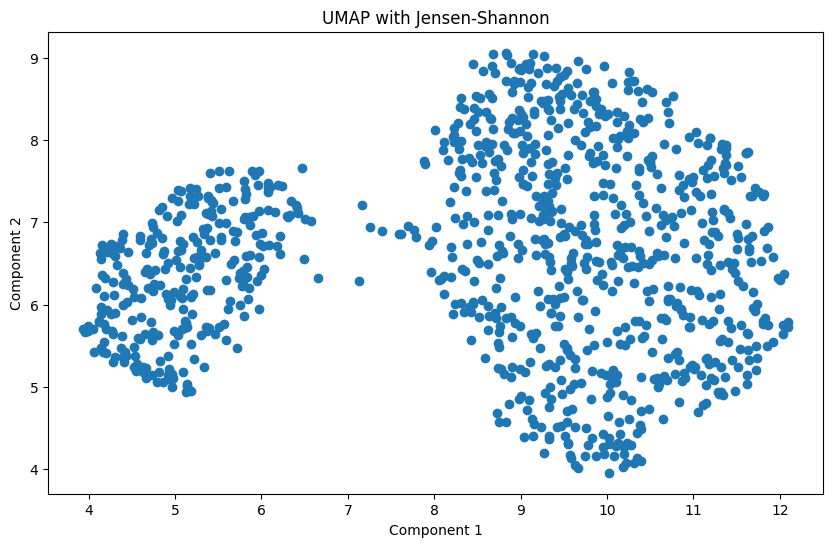

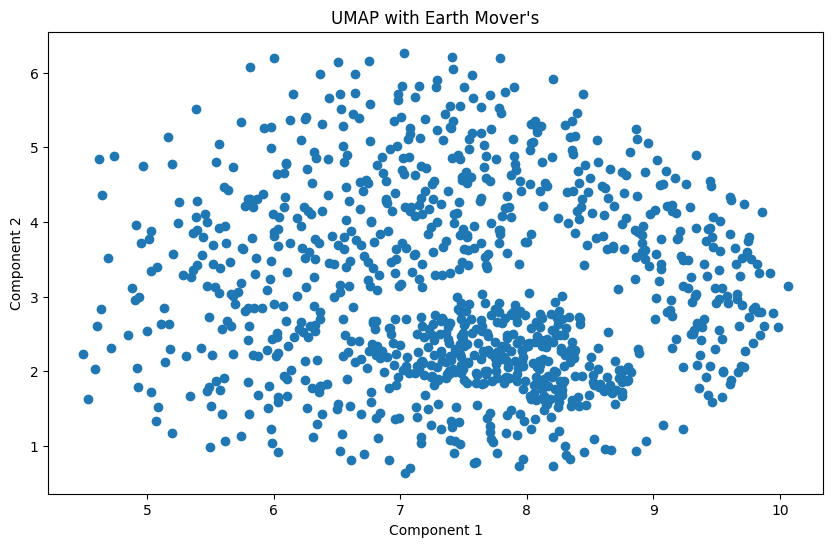

In [32]:
import numpy as np
from scipy.special import kl_div
from scipy.linalg import sqrtm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from data import get_DYDA, get_SWDA, get_KPN

import numpy as np
from scipy.special import kl_div
from scipy.spatial import distance
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from umap import UMAP
import ot
import matplotlib.pyplot as plt


def a():
    train, test = get_SWDA()

    # Assuming your sequences are in a list of lists called 'sequences'
    sequences = train[1]  # replace with your data
    num_labels = np.unique(np.concatenate(sequences)).shape[0]

    # Calculate frequency distributions
    freq_distributions = []
    for seq in sequences:
        freq_distribution = [seq.count(i) for i in range(num_labels)]  # range goes up to 46
        freq_distributions.append(freq_distribution)

    # Convert counts to probabilities with smoothing
    epsilon = 1e-10  # small constant
    probs = [
        (np.array(dist) + epsilon) / (sum(dist) + epsilon * num_labels)
        for dist in freq_distributions
    ]

    # Compute divergence/distance matrices
    n = len(probs)
    js_divergence_matrix = np.zeros((n, n))
    emd_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            # Jensen-Shannon divergence
            kl_ij = kl_div(probs[i], probs[j]).sum()
            kl_ji = kl_div(probs[j], probs[i]).sum()
            js_divergence = (kl_ij + kl_ji) / 2
            js_divergence_matrix[i, j] = js_divergence
            js_divergence_matrix[j, i] = js_divergence  # symmetry

            # Earth Mover's Distance
            emd = ot.emd2(probs[i], probs[j], np.ones((num_labels, num_labels)))
            emd_matrix[i, j] = emd
            emd_matrix[j, i] = emd  # symmetry

    # Apply clustering algorithms to divergence/distance matrices
    algorithms = {
        "t-SNE": TSNE(
            metric="precomputed",
            perplexity=30,
            n_components=2,
            # init="pca",
            n_iter=1000,
            random_state=23,
        ),
        "UMAP": UMAP(
            metric="precomputed",
            n_neighbors=15,
            min_dist=0.1,
            n_components=2,
            random_state=23,
        ),
    }

    results = {}
    for name, algo in algorithms.items():
        for matrix, mat_name in zip(
            [js_divergence_matrix, emd_matrix], ["Jensen-Shannon", "Earth Mover's"]
        ):
            coords = algo.fit_transform(matrix)
            results[name + " with " + mat_name] = coords

    # Plot results
    for name, res in results.items():
        plt.figure(figsize=(10, 6))
        plt.scatter(res[:, 0], res[:, 1])
        plt.title(name)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.show()


a()

# Check Entropy of Dataset